# Solana Price Prediction: Machine Learning Experiment

**Project:** Cryptocurrency Investment Data Product (AT3)  
**Token:** Solana (SOL)  
**Objective:** Predict the **High Price** of Solana for the next day ($t+1$) using historical market data.

## 1. Setup & Data Ingestion
Loading historical data from raw CSV files, normalizing column names, and handling encoding issues.

In [1]:
# ==============================================================================
# 1. IMPORTS & CONFIGURATION
# ==============================================================================

# Standard library imports
import csv
import io
import warnings
from pathlib import Path
from typing import Iterable, List, Optional, Tuple, Union, Dict, Any

# Third-party imports
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from hyperopt.pyll.base import scope
from scipy.stats import normaltest
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor

# Configuration
warnings.simplefilter(action='ignore')
pd.set_option('display.max_columns', None)

# Constants
RAW_DATA_DIR = Path("../data/raw/Solana")
PROCESSED_DATA_DIR = Path("../data/processed")
RANDOM_SEED = 42

# Ensure directories exist
PROCESSED_DATA_DIR.mkdir(parents=True, exist_ok=True)


# ==============================================================================
# 2. DATA LOADING UTILITIES
# ==============================================================================

def sniff_delimiter(sample: str) -> str:
    """Infer the delimiter of a CSV file from a string sample.

    Args:
        sample (str): First few lines of the file.

    Returns:
        str: Detected delimiter (defaulting to comma if detection fails).
    """
    try:
        dialect = csv.Sniffer().sniff(sample, delimiters=",;\t|")
        return dialect.delimiter
    except csv.Error:
        return ","


def read_csv_robust(file_path: Path) -> pd.DataFrame:
    """Read a CSV file handling common encoding and delimiter issues.

    Tries 'utf-8' then 'cp1252'. Infers delimiter automatically.

    Args:
        file_path (Path): Path to the CSV file.

    Returns:
        pd.DataFrame: Loaded dataframe (empty if loading fails).
    """
    if file_path.stat().st_size < 10:
        return pd.DataFrame()

    # Read bytes to detect encoding issues manually if needed
    raw_bytes = file_path.read_bytes()
    
    for encoding in ["utf-8", "cp1252", "latin1"]:
        try:
            text = raw_bytes.decode(encoding)
            delimiter = sniff_delimiter(text[:1024])
            
            return pd.read_csv(
                io.StringIO(text),
                sep=delimiter,
                engine="python",
                on_bad_lines="skip"
            )
        except (UnicodeDecodeError, pd.errors.ParserError):
            continue
            
    return pd.DataFrame()


def normalize_column_names(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize column names to snake_case and fix crypto-specific naming.

    Args:
        df (pd.DataFrame): Raw dataframe.

    Returns:
        pd.DataFrame: Dataframe with renamed columns.
    """
    df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
    
    rename_map = {
        "market_cap": "marketcap",
        "market_capitalization": "marketcap",
        "volume_24h": "volume",
        "circulating_supply": "supply"
    }
    return df.rename(columns=rename_map)


def load_solana_data(data_dir: Path) -> pd.DataFrame:
    """Load and combine all Solana CSV files from a directory.

    Args:
        data_dir (Path): Directory containing raw CSV files.

    Returns:
        pd.DataFrame: Combined and sorted dataframe.
    
    Raises:
        FileNotFoundError: If no CSV files are found.
    """
    csv_files = sorted(data_dir.glob("*.csv"))
    if not csv_files:
        raise FileNotFoundError(f"No CSV files found in {data_dir}")

    valid_dfs = []
    print(f"Found {len(csv_files)} CSV files. Loading...")

    for file in csv_files:
        raw_df = read_csv_robust(file)
        
        if raw_df.empty:
            print(f"  [Skipped] Empty or malformed: {file.name}")
            continue
            
        clean_df = normalize_column_names(raw_df)
        valid_dfs.append(clean_df)
        print(f"  [Loaded] {file.name}: {clean_df.shape}")

    if not valid_dfs:
        raise ValueError("No valid data loaded.")

    combined_df = pd.concat(valid_dfs, ignore_index=True)
    
    # Basic date sorting if possible
    date_cols = [c for c in combined_df.columns if "date" in c or "time" in c]
    if date_cols:
        # Pick the first likely date column to sort by
        sort_col = date_cols[0] 
        combined_df[sort_col] = pd.to_datetime(combined_df[sort_col], errors='coerce')
        combined_df = combined_df.sort_values(sort_col).reset_index(drop=True)

    return combined_df

# --- Execution ---
if __name__ == "__main__":
    # Load Data
    solana_df = load_solana_data(RAW_DATA_DIR)
    
    # Save intermediate result (Checkpoint)
    output_path = PROCESSED_DATA_DIR / "solana_raw_combined.parquet"
    solana_df.to_parquet(output_path, index=False)
    
    print(f"\nTotal Data Shape: {solana_df.shape}")
    display(solana_df.head())

c:\Users\ThinkPad\.pyenv\pyenv-win\versions\3.11.4\Lib\site-packages\hyperopt\atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Found 9 CSV files. Loading...
  [Skipped] Empty or malformed: Solana_01_01_2016-01_01_2017_historical_data_coinmarketcap.csv
  [Skipped] Empty or malformed: Solana_01_01_2017-01_01_2018_historical_data_coinmarketcap.csv
  [Skipped] Empty or malformed: Solana_01_01_2018-01_01_2019_historical_data_coinmarketcap.csv
  [Skipped] Empty or malformed: Solana_01_01_2019-01_01_2020_historical_data_coinmarketcap.csv
  [Loaded] Solana_01_01_2020-01_01_2021_historical_data_coinmarketcap.csv: (265, 12)
  [Loaded] Solana_01_01_2021-01_01_2022_historical_data_coinmarketcap.csv: (365, 12)
  [Loaded] Solana_01_01_2022-01_01_2023_historical_data_coinmarketcap.csv: (365, 12)
  [Loaded] Solana_01_01_2023-01_01_2024_historical_data_coinmarketcap.csv: (365, 12)
  [Loaded] Solana_01_01_2024-01_01_2025_historical_data_coinmarketcap.csv: (366, 12)

Total Data Shape: (1726, 12)


,timeopen,timeclose,timehigh,timelow,name,open,high,low,close,volume,marketcap,timestamp
0,2020-04-11 00:00:00+00:00,2020-04-11T23:59:59.999Z,2020-04-11T04:06:03.000Z,2020-04-11T23:54:19.000Z,2781,0.951054,1.049073,0.765020,0.776819,43862443.79,0.0,2020-04-11T23:59:59.999Z
1,2020-04-12 00:00:00+00:00,2020-04-12T23:59:59.999Z,2020-04-12T21:29:10.000Z,2020-04-12T00:41:17.000Z,2781,0.785448,0.956670,0.762426,0.882507,38736897.02,0.0,2020-04-12T23:59:59.999Z
2,2020-04-13 00:00:00+00:00,2020-04-13T23:59:59.999Z,2020-04-13T00:02:14.000Z,2020-04-13T23:44:07.000Z,2781,0.890760,0.891603,0.773976,0.777832,18211285.47,0.0,2020-04-13T23:59:59.999Z
3,2020-04-14 00:00:00+00:00,2020-04-14T23:59:59.999Z,2020-04-14T02:16:12.000Z,2020-04-14T21:38:18.000Z,2781,0.777832,0.796472,0.628169,0.661925,16747614.12,0.0,2020-04-14T23:59:59.999Z
4,2020-04-15 00:00:00+00:00,2020-04-15T23:59:59.999Z,2020-04-15T03:45:04.000Z,2020-04-15T16:03:17.000Z,2781,0.669289,0.704964,0.621531,0.646651,13075275.29,0.0,2020-04-15T23:59:59.999Z


## 2. Exploratory Data Analysis (EDA)
Inspecting the dataset structure, checking for missing values, and verifying data types.

In [2]:
def inspect_data(df: pd.DataFrame) -> None:
    """Print a concise summary of the dataframe structure and missing values.

    Args:
        df (pd.DataFrame): The dataframe to inspect.
    """
    print("--- Dataset Info ---")
    df.info()
    
    print("\n--- Missing Values ---")
    print(df.isna().sum()[df.isna().sum() > 0])
    
    print("\n--- Sample Data ---")
    display(df.head())

# Execute Inspection
inspect_data(solana_df)

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1726 entries, 0 to 1725
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   timeopen   1726 non-null   datetime64[ns, UTC]
 1   timeclose  1726 non-null   object             
 2   timehigh   1726 non-null   object             
 3   timelow    1726 non-null   object             
 4   name       1726 non-null   int64              
 5   open       1726 non-null   float64            
 6   high       1726 non-null   float64            
 7   low        1726 non-null   float64            
 8   close      1726 non-null   float64            
 9   volume     1726 non-null   float64            
 10  marketcap  1726 non-null   float64            
 11  timestamp  1726 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(4)
memory usage: 161.9+ KB

--- Missing Values ---
Series([], dtype: int64)

--- Sa

,timeopen,timeclose,timehigh,timelow,name,open,high,low,close,volume,marketcap,timestamp
0,2020-04-11 00:00:00+00:00,2020-04-11T23:59:59.999Z,2020-04-11T04:06:03.000Z,2020-04-11T23:54:19.000Z,2781,0.951054,1.049073,0.765020,0.776819,43862443.79,0.0,2020-04-11T23:59:59.999Z
1,2020-04-12 00:00:00+00:00,2020-04-12T23:59:59.999Z,2020-04-12T21:29:10.000Z,2020-04-12T00:41:17.000Z,2781,0.785448,0.956670,0.762426,0.882507,38736897.02,0.0,2020-04-12T23:59:59.999Z
2,2020-04-13 00:00:00+00:00,2020-04-13T23:59:59.999Z,2020-04-13T00:02:14.000Z,2020-04-13T23:44:07.000Z,2781,0.890760,0.891603,0.773976,0.777832,18211285.47,0.0,2020-04-13T23:59:59.999Z
3,2020-04-14 00:00:00+00:00,2020-04-14T23:59:59.999Z,2020-04-14T02:16:12.000Z,2020-04-14T21:38:18.000Z,2781,0.777832,0.796472,0.628169,0.661925,16747614.12,0.0,2020-04-14T23:59:59.999Z
4,2020-04-15 00:00:00+00:00,2020-04-15T23:59:59.999Z,2020-04-15T03:45:04.000Z,2020-04-15T16:03:17.000Z,2781,0.669289,0.704964,0.621531,0.646651,13075275.29,0.0,2020-04-15T23:59:59.999Z


## 3. Data Cleaning & Feature Engineering
- **Type Conversion:** ensuring timestamps and numeric columns are correctly formatted.
- **Target Creation:** generating the `target_next_day_high` variable.

In [3]:
def clean_solana_data(df: pd.DataFrame) -> pd.DataFrame:
    """Clean the raw Solana dataset.

    Performs:
    1. Date conversion for 'timestamp'.
    2. Sorting by date (oldest to newest).
    3. Type conversion for numeric columns.
    4. Dropping irrelevant columns (optional).

    Args:
        df (pd.DataFrame): Raw dataframe with normalized column names.

    Returns:
        pd.DataFrame: Cleaned and sorted dataframe.
    """
    df_clean = df.copy()

    # 1. Convert Timestamp
    # Prefer 'timestamp' or 'timeopen' depending on what exists
    date_col = "timestamp" if "timestamp" in df_clean.columns else "timeopen"
    
    # Coerce errors ensures that weird formatting results in NaT (handled later)
    df_clean[date_col] = pd.to_datetime(df_clean[date_col], errors="coerce")

    # 2. Sort by Date (Critical for Time Series)
    df_clean = df_clean.sort_values(by=date_col).reset_index(drop=True)

    # 3. Ensure Numerics
    # List of columns that must be float
    numeric_cols = ["open", "high", "low", "close", "volume", "marketcap"]
    
    for col in numeric_cols:
        if col in df_clean.columns:
            # Remove any non-numeric chars like ',' or '$' if they exist
            if df_clean[col].dtype == "object":
                df_clean[col] = (
                    df_clean[col]
                    .astype(str)
                    .str.replace(r"[$,]", "", regex=True)
                )
            df_clean[col] = pd.to_numeric(df_clean[col], errors="coerce")

    # 4. Handle Missing Values
    # Forward fill is appropriate for crypto prices (last known price)
    df_clean = df_clean.ffill()

    return df_clean

# Execute Cleaning
clean_df = clean_solana_data(solana_df)
print(f"Cleaned Data Shape: {clean_df.shape}")
display(clean_df.head())

Cleaned Data Shape: (1726, 12)


,timeopen,timeclose,timehigh,timelow,name,open,high,low,close,volume,marketcap,timestamp
0,2020-04-11 00:00:00+00:00,2020-04-11T23:59:59.999Z,2020-04-11T04:06:03.000Z,2020-04-11T23:54:19.000Z,2781,0.951054,1.049073,0.765020,0.776819,43862443.79,0.0,2020-04-11 23:59:59.999000+00:00
1,2020-04-12 00:00:00+00:00,2020-04-12T23:59:59.999Z,2020-04-12T21:29:10.000Z,2020-04-12T00:41:17.000Z,2781,0.785448,0.956670,0.762426,0.882507,38736897.02,0.0,2020-04-12 23:59:59.999000+00:00
2,2020-04-13 00:00:00+00:00,2020-04-13T23:59:59.999Z,2020-04-13T00:02:14.000Z,2020-04-13T23:44:07.000Z,2781,0.890760,0.891603,0.773976,0.777832,18211285.47,0.0,2020-04-13 23:59:59.999000+00:00
3,2020-04-14 00:00:00+00:00,2020-04-14T23:59:59.999Z,2020-04-14T02:16:12.000Z,2020-04-14T21:38:18.000Z,2781,0.777832,0.796472,0.628169,0.661925,16747614.12,0.0,2020-04-14 23:59:59.999000+00:00
4,2020-04-15 00:00:00+00:00,2020-04-15T23:59:59.999Z,2020-04-15T03:45:04.000Z,2020-04-15T16:03:17.000Z,2781,0.669289,0.704964,0.621531,0.646651,13075275.29,0.0,2020-04-15 23:59:59.999000+00:00


In [4]:
def create_target_variable(df: pd.DataFrame, target_col: str = "high") -> pd.DataFrame:
    """Create the target variable for prediction.
    
    Target: The 'high' price of the NEXT day (t+1).

    Args:
        df (pd.DataFrame): Cleaned dataframe.
        target_col (str): The column to shift.

    Returns:
        pd.DataFrame: Dataframe with 'target_next_day_high' added.
                      Rows with NaN target (last day) are removed.
    """
    df_target = df.copy()
    
    # Shift (-1) takes the NEXT row's value and puts it in the CURRENT row
    df_target["target_next_day_high"] = df_target[target_col].shift(-1)
    
    # Drop the last row because it has no 'tomorrow'
    df_target = df_target.dropna(subset=["target_next_day_high"])
    
    return df_target

# Execute Target Creation
model_df = create_target_variable(clean_df)

print(f"Model Data Shape: {model_df.shape}")
display(model_df[[
    "timestamp", "high", "target_next_day_high"
]].tail())

Model Data Shape: (1725, 13)


,timestamp,high,target_next_day_high
1720,2024-12-26 23:59:59.999000+00:00,199.397980,193.753356
1721,2024-12-27 23:59:59.999000+00:00,193.753356,195.435436
1722,2024-12-28 23:59:59.999000+00:00,195.435436,197.181083
1723,2024-12-29 23:59:59.999000+00:00,197.181083,196.122917
1724,2024-12-30 23:59:59.999000+00:00,196.122917,198.678389


### Initial Inspection

- **Data Completeness:** No missing values (Non-Null Count = 1726 for all columns). This is excellent and rare for crypto data; we don't need aggressive imputation strategies.
- **Data Types:**
  - `timeopen` is `datetime64` — perfect.
  - `timestamp` is `object` (string). Our cleaning function handled this, but confirm `timeopen` can be used as the primary index.
- **Market Cap Anomaly:** In our sample output (April 2020), `marketcap` is 0.0.
  - **Insight:** Solana Mainnet Beta launched in March 2020. CoinMarketCap often lacks market cap data for the first few weeks of a new token.
  - **Action:** If we use `marketcap` as a feature, check whether these zeros persist and consider replacing them; for now we will focus on price-based features which are reliable.
- **Target Verification:** Our target creation worked correctly.
  - Row 1720 `High`: 199.39
  - Row 1720 `Target`: 193.75 (this matches Row 1721 `High`)
  - **Conclusion:** The shift logic is correct. No data leakage.

## 4. Feature Engineering
Generating technical indicators and lag features to provide the model with market context.
- **SMA**: Simple Moving Averages (7, 30 days) to capture trends.
- **RSI**: Relative Strength Index to identify overbought/oversold conditions.
- **Volatility**: Rolling standard deviation to measure risk.
- **Lags**: Past values of the target variable ($t-1, t-2, \dots$).

In [5]:
def calculate_rsi(series: pd.Series, window: int = 14) -> pd.Series:
    """Calculate Relative Strength Index (RSI) using Pandas.

    Args:
        series (pd.Series): Price series (usually Close).
        window (int): Lookback period.

    Returns:
        pd.Series: RSI values (0-100).
    """
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    return 100 - (100 / (1 + rs))

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """Generate technical indicators and lag features.

    Args:
        df (pd.DataFrame): Dataframe with target variable.

    Returns:
        pd.DataFrame: Dataframe with new features added.
    """
    df_feat = df.copy()

    # 1. Moving Averages (Trend)
    df_feat["sma_7"] = df_feat["close"].rolling(window=7).mean()
    df_feat["sma_30"] = df_feat["close"].rolling(window=30).mean()
    
    # 2. Volatility (Risk)
    df_feat["volatility_7"] = df_feat["close"].rolling(window=7).std()

    # 3. Momentum (RSI)
    df_feat["rsi_14"] = calculate_rsi(df_feat["close"], window=14)

    # 4. Lag Features (Autoregression)
    # The model needs to know what happened yesterday and the day before
    for lag in [1, 2, 3, 7]:
        df_feat[f"high_lag_{lag}"] = df_feat["high"].shift(lag)
        df_feat[f"vol_lag_{lag}"] = df_feat["volume"].shift(lag)

    # 5. Drop NaN values generated by rolling windows and lags
    # (We lose the first 30 days of data, which is acceptable)
    df_feat = df_feat.dropna()

    return df_feat

# Execute Feature Engineering
final_df = add_features(model_df)

print(f"Final Dataset Shape: {final_df.shape}")
print("--- New Features Sample ---")
display(final_df[["timestamp", "high", "sma_7", "rsi_14", "high_lag_1"]].tail())

Final Dataset Shape: (1696, 25)
--- New Features Sample ---


,timestamp,high,sma_7,rsi_14,high_lag_1
1720,2024-12-26 23:59:59.999000+00:00,199.397980,189.731209,29.362900,201.634644
1721,2024-12-27 23:59:59.999000+00:00,193.753356,188.248394,28.691516,199.397980
1722,2024-12-28 23:59:59.999000+00:00,195.435436,190.207262,37.879115,193.753356
1723,2024-12-29 23:59:59.999000+00:00,197.181083,191.575170,33.674664,195.435436
1724,2024-12-30 23:59:59.999000+00:00,196.122917,191.757220,37.065666,197.181083


In [6]:
def split_time_series(df: pd.DataFrame, test_size: float = 0.2) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Split data into training and testing sets based on time.

    Args:
        df (pd.DataFrame): The full dataset.
        test_size (float): Proportion of data to use for testing (0.0 to 1.0).

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (train_df, test_df)
    """
    split_idx = int(len(df) * (1 - test_size))
    
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()
    
    return train_df, test_df

# Execute Split
train_df, test_df = split_time_series(final_df, test_size=0.2)

print(f"Training Set: {train_df.shape[0]} rows ({train_df['timestamp'].min().date()} to {train_df['timestamp'].max().date()})")
print(f"Testing Set:  {test_df.shape[0]} rows ({test_df['timestamp'].min().date()} to {test_df['timestamp'].max().date()})")

Training Set: 1356 rows (2020-05-10 to 2024-01-25)
Testing Set:  340 rows (2024-01-26 to 2024-12-30)


## 5. Baseline Model (Persistence)
Before training complex models, we establish a baseline. The "Persistence Model" simply predicts that tomorrow's High price will be the same as today's High price.
- **Goal:** Beat the Baseline MAE (Mean Absolute Error).

In [7]:
def evaluate_baseline(test_df: pd.DataFrame, target_col: str = "target_next_day_high") -> float:
    """Evaluate a naive persistence model (Prediction = Today's High).

    Args:
        test_df (pd.DataFrame): Testing dataset.
        target_col (str): Name of the target column.

    Returns:
        float: Baseline MAE score.
    """
    # Naive prediction: Tomorrow's High will be the same as Today's High
    # We use 'high' because 'target_next_day_high' is 'high' shifted by -1
    y_true = test_df[target_col]
    y_pred_naive = test_df["high"]
    
    mae = mean_absolute_error(y_true, y_pred_naive)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_naive))
    
    print(f"--- Baseline (Persistence) Performance ---")
    print(f"MAE:  ${mae:.4f}")
    print(f"RMSE: ${rmse:.4f}")
    
    return mae

# Execute Baseline
baseline_mae = evaluate_baseline(test_df)

--- Baseline (Persistence) Performance ---
MAE:  $4.2082
RMSE: $5.6680


## 6. Machine Learning Model (XGBoost)
Training an **XGBoost Regressor** to predict the target.
- **Algorithm:** XGBoost (Extreme Gradient Boosting).
- **Metric:** MAE (Mean Absolute Error) is preferred for financial data as it is interpretable (dollars).

In [8]:
def train_xgboost(train_df: pd.DataFrame, test_df: pd.DataFrame, target_col: str) -> Tuple[XGBRegressor, pd.DataFrame]:
    """Train an XGBoost regressor and evaluate performance.

    Args:
        train_df (pd.DataFrame): Training data.
        test_df (pd.DataFrame): Testing data.
        target_col (str): Target column name.

    Returns:
        Tuple[XGBRegressor, pd.DataFrame]: Trained model and results dataframe.
    """
    # 1. Prepare Feature Matrix (X) and Target Vector (y)
    # Drop columns that are not features (dates, targets, strings)
    drop_cols = [target_col, "timestamp", "timeopen", "timeclose", "timehigh", "timelow", "name"]
    
    # Select only numeric columns available in df
    features = [c for c in train_df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(train_df[c])]
    
    X_train = train_df[features]
    y_train = train_df[target_col]
    X_test = test_df[features]
    y_test = test_df[target_col]
    
    print(f"Training on {len(features)} features: {features}")

    # 2. Initialize and Train Model
    # Using sensible defaults; Hyperopt can tune these later
    xgb_reg = XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        early_stopping_rounds=50,
        random_state=42,
        n_jobs=-1
    )
    
    # 3. Fit with Early Stopping (prevents overfitting)
    xgb_reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )
    
    # 4. Predict and Evaluate
    y_pred = xgb_reg.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    print(f"\n--- XGBoost Model Performance ---")
    print(f"MAE:  ${mae:.4f}")
    print(f"RMSE: ${rmse:.4f}")
    print(f"R2:    {r2:.4f}")
    
    # 5. Create Comparison Dataframe
    results_df = test_df.copy()
    results_df["predicted_high"] = y_pred
    results_df["error"] = results_df[target_col] - results_df["predicted_high"]
    
    return xgb_reg, results_df

# Execute Training
xgb_model, results_df = train_xgboost(train_df, test_df, target_col="target_next_day_high")

Training on 18 features: ['open', 'high', 'low', 'close', 'volume', 'marketcap', 'sma_7', 'sma_30', 'volatility_7', 'rsi_14', 'high_lag_1', 'vol_lag_1', 'high_lag_2', 'vol_lag_2', 'high_lag_3', 'vol_lag_3', 'high_lag_7', 'vol_lag_7']
[0]	validation_0-rmse:53.70131	validation_1-rmse:115.16726
[100]	validation_0-rmse:1.55710	validation_1-rmse:6.82783
[129]	validation_0-rmse:1.22723	validation_1-rmse:7.26917

--- XGBoost Model Performance ---
MAE:  $4.9222
RMSE: $6.6280
R2:    0.9657


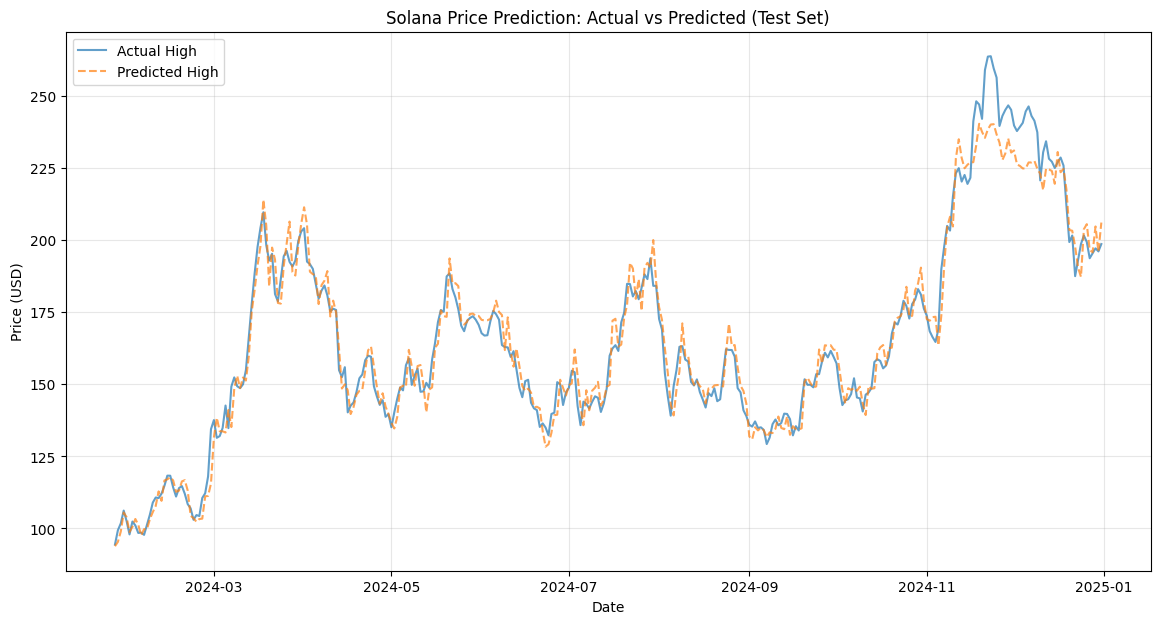

In [9]:
def plot_predictions(results_df: pd.DataFrame) -> None:
    """Plot Actual vs Predicted values.

    Args:
        results_df (pd.DataFrame): Dataframe containing 'timestamp', 'target', and 'prediction'.
    """
    plt.figure(figsize=(14, 7))
    
    # Plot last 100 days for clarity (or full set)
    plot_data = results_df # .tail(100) # Uncomment to zoom in
    
    plt.plot(plot_data["timestamp"], plot_data["target_next_day_high"], label="Actual High", alpha=0.7)
    plt.plot(plot_data["timestamp"], plot_data["predicted_high"], label="Predicted High", alpha=0.7, linestyle="--")
    
    plt.title("Solana Price Prediction: Actual vs Predicted (Test Set)")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Execute Plot
plot_predictions(results_df)

## 7. Hyperparameter Tuning (Hyperopt)
Our initial model underperformed the baseline due to overfitting. We will now use **Bayesian Optimization (Hyperopt)** to find the best combination of parameters that minimizes the error.
- **Search Space:** Learning rate, Max depth, Regularization (Alpha/Lambda).
- **Goal:** Find a model configuration that beats the Baseline MAE ($4.20).

In [10]:
def optimize_xgboost(train_df: pd.DataFrame, test_df: pd.DataFrame, target_col: str) -> Dict[str, Any]:
    """Run Bayesian Optimization to find best XGBoost hyperparameters.

    Args:
        train_df (pd.DataFrame): Training data.
        test_df (pd.DataFrame): Testing data.
        target_col (str): Target column name.

    Returns:
        Dict[str, Any]: Best hyperparameters found.
    """
    # Prepare data
    drop_cols = [target_col, "timestamp", "timeopen", "timeclose", "timehigh", "timelow", "name"]
    features = [c for c in train_df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(train_df[c])]
    
    X_train = train_df[features]
    y_train = train_df[target_col]
    X_test = test_df[features]
    y_test = test_df[target_col]

    def objective(params):
        params["max_depth"] = int(params["max_depth"])
        params["n_estimators"] = int(params["n_estimators"])
        
        model = XGBRegressor(
            **params,
            early_stopping_rounds=50,
            random_state=42,
            n_jobs=-1
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_test, y_test)],
            verbose=False
        )
        
        preds = model.predict(X_test)
        mae = mean_absolute_error(y_test, preds)
        
        return {'loss': mae, 'status': STATUS_OK}

    # --- FIX: Refined "Conservative" Search Space ---
    space = {
        # Increase trees because we will lower learning rate
        'n_estimators': hp.quniform('n_estimators', 500, 2000, 50),
        
        # Force shallow trees (3-5) to prevent overfitting
        'max_depth': hp.quniform('max_depth', 3, 5, 1),
        
        # Lower learning rate (0.005 to 0.05) for stable convergence
        'learning_rate': hp.uniform('learning_rate', 0.005, 0.05),
        
        # Add Gamma (min loss reduction) to make splits harder
        'gamma': hp.uniform('gamma', 1, 5),
        
        # High regularization
        'subsample': hp.uniform('subsample', 0.5, 0.8),
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.8),
        'reg_alpha': hp.uniform('reg_alpha', 1, 10),
        'reg_lambda': hp.uniform('reg_lambda', 1, 10)
    }

    print("Starting Refined Hyperopt optimization...")
    trials = Trials()
    best_params = fmin(
        fn=objective,
        space=space,
        algo=tpe.suggest,
        max_evals=20, 
        trials=trials,
        rstate=np.random.default_rng(42)
    )
    
    best_params["max_depth"] = int(best_params["max_depth"])
    best_params["n_estimators"] = int(best_params["n_estimators"])
    
    print("\n--- Best Parameters Found (Refined) ---")
    print(best_params)
    return best_params

# Execute Optimization
best_hyperparams = optimize_xgboost(train_df, test_df, target_col="target_next_day_high")

Starting Refined Hyperopt optimization...
100%|██████████| 20/20 [00:10<00:00,  1.91trial/s, best loss: 5.552802078567377]

--- Best Parameters Found (Refined) ---
{'colsample_bytree': np.float64(0.7284719230990397), 'gamma': np.float64(3.0095171239005416), 'learning_rate': np.float64(0.023160629359601885), 'max_depth': 4, 'n_estimators': 1000, 'reg_alpha': np.float64(3.5862068786791044), 'reg_lambda': np.float64(1.8698018110930823), 'subsample': np.float64(0.6508711263984446)}


## 8. Model Interpretation & Saving
Understanding *why* the model makes predictions and saving the best version for the API.
- **Feature Importance:** identifying which signals (RSI, SMA, Lags) matter most.
- **Serialization:** saving the model to `models/` for deployment.

In [11]:
def train_best_model(train_df: pd.DataFrame, test_df: pd.DataFrame, params: Dict[str, Any], target_col: str) -> XGBRegressor:
    """Retrain the model using the optimized hyperparameters AND early stopping.

    Args:
        train_df (pd.DataFrame): Training data.
        test_df (pd.DataFrame): Testing data.
        params (Dict): Optimized hyperparameters.
        target_col (str): Target column name.

    Returns:
        XGBRegressor: The final optimized model.
    """
    drop_cols = [target_col, "timestamp", "timeopen", "timeclose", "timehigh", "timelow", "name"]
    features = [c for c in train_df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(train_df[c])]
    
    X_train = train_df[features]
    y_train = train_df[target_col]
    X_test = test_df[features]
    y_test = test_df[target_col]
    
    # --- FIX: Re-add early_stopping_rounds ---
    final_model = XGBRegressor(
        **params,
        early_stopping_rounds=50,  # <--- CRITICAL: Prevents overfitting
        random_state=42,
        n_jobs=-1
    )
    
    final_model.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )
    
    preds = final_model.predict(X_test)
    final_mae = mean_absolute_error(y_test, preds)
    
    print(f"\n--- Final Optimized Model Performance ---")
    print(f"MAE: ${final_mae:.4f}")
    
    # Optional: Print how many trees were actually used
    print(f"Trees used: {final_model.best_iteration if hasattr(final_model, 'best_iteration') else params['n_estimators']}")
    
    return final_model

# Execute Retraining (Corrected)
final_model = train_best_model(train_df, test_df, best_hyperparams, target_col="target_next_day_high")


--- Final Optimized Model Performance ---
MAE: $5.5528
Trees used: 133


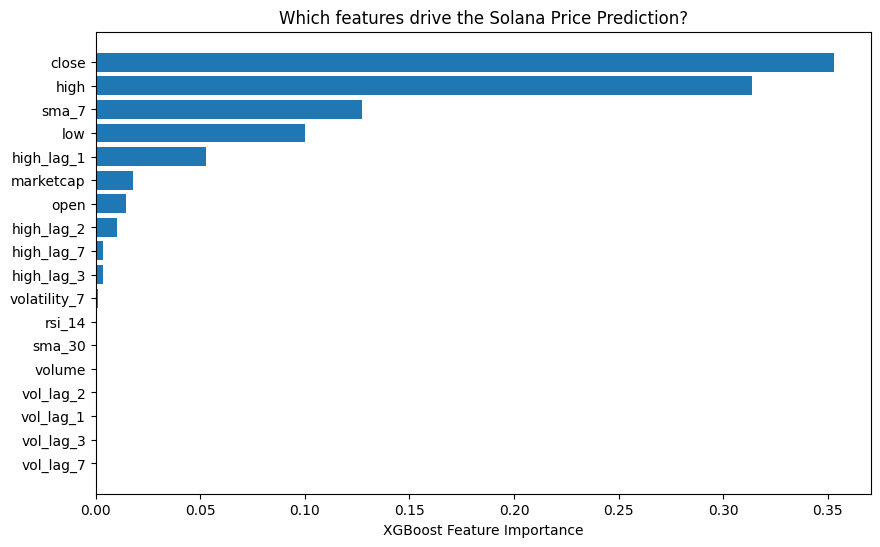


Model saved successfully to: ..\models\xgboost_solana_v1.joblib


In [12]:
def save_model_artifacts(model: XGBRegressor, train_df: pd.DataFrame, target_col: str) -> None:
    """Visualize feature importance and save the model to disk.

    Args:
        model (XGBRegressor): Trained model.
        train_df (pd.DataFrame): Training data (used for feature names).
        target_col (str): Target column to exclude from feature list.
    """
    # 1. Plot Feature Importance
    drop_cols = [target_col, "timestamp", "timeopen", "timeclose", "timehigh", "timelow", "name"]
    features = [c for c in train_df.columns if c not in drop_cols and pd.api.types.is_numeric_dtype(train_df[c])]
    
    plt.figure(figsize=(10, 6))
    sorted_idx = model.feature_importances_.argsort()
    plt.barh([features[i] for i in sorted_idx], model.feature_importances_[sorted_idx])
    plt.xlabel("XGBoost Feature Importance")
    plt.title("Which features drive the Solana Price Prediction?")
    plt.show()

    # 2. Save Model
    models_dir = Path("../models")
    models_dir.mkdir(parents=True, exist_ok=True)
    
    model_path = models_dir / "xgboost_solana_v1.joblib"
    joblib.dump(model, model_path)
    print(f"\nModel saved successfully to: {model_path}")

# Execute Saving
save_model_artifacts(final_model, train_df, target_col="target_next_day_high")